### Alunos
- Alexandre Candido Souza
- Klarissa Andrade de Morais

# Introdução

In [260]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split



plt.style.use('default')

trainData = pd.read_csv('./input/train.csv')
testData = pd.read_csv('./input/test.csv')
result = pd.read_csv('./input/results.csv')

testData = pd.concat([testData, result["Survived"]], axis=1)

Os dados seguiam o seguinte formato:

| Variável | Definição | Valores |
|---|---|---|
| Pclass | Classe do Bilhete | 1 \| 2 \| 3 |
| Sex | Sexo | "male" \| "female" |
| Age | Idade | Anos (fracional se menor que 1)|
| Sibsp | Qtd de irmãos/conjugues a bordo |  |
| Parch | Qtd de pais/filhos a bordo |  |
| Ticket | Numero do Ticket |  |
| Fare | Taxa de passagem |  |
| Cabin | Numero da Cabine |  |
| Embarked | Porto de Embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

Removemos de cara os valores que não interessavam para a previsão.

In [261]:
trainData = trainData.drop(["Cabin","Ticket","Name", "PassengerId"], axis=1)
testData = testData.drop(["Cabin","Ticket","Name", "PassengerId"], axis=1)

Percebemos que háviam muitas idades inválidas. É importante saber quantas e se outras colunas também estavam com dados faltando, e se for o caso, trata-los

In [262]:
print("Training DataSet:")
print(trainData.isna().sum())
print("Test DataSet:")
print(testData.isna().sum())

Training DataSet:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
Test DataSet:
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
Survived     0
dtype: int64


Usamos o `InterativeImputer` do `Scikit`, que basicamente tenta aproximar o valor que está faltando na coluna idade à partir das outras 2 colunas, iterando recursivamente até chegar em um valor que talvez seja próximo do valor real, podemos parametrizar ele mais, mas deixamos no comportamento padrão.  
> Existem outros métodos de se imputar valores como o `SimpleImputer`, ou simplesmente tentar fazer uma média, moda ou mediana para preencher os valores que estão faltando. Mas no nosso caso o InterativeImputer funcionou bem.

qtd de idades inválidas: 0


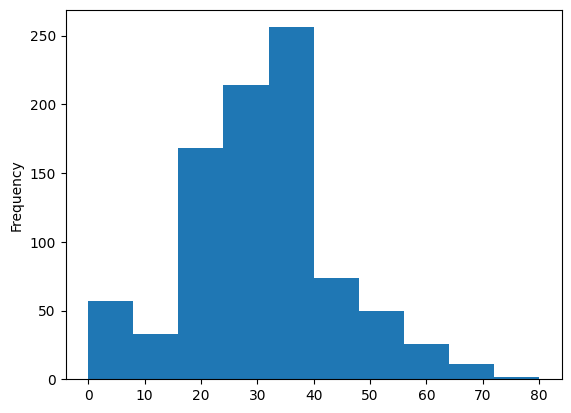

In [263]:
columns = ["SibSp", "Parch", "Age"]
imputer = IterativeImputer(min_value = 0)

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
trainData["Age"] = correctedValues["Age"]

imputedValues = imputer.fit_transform(testData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
testData["Age"] = correctedValues["Age"]

trainData["Age"].plot(kind='hist')
print(f"qtd de idades inválidas: {trainData['Age'].isna().sum()}")

Para conseguir plotar o gráfico corretamnete, tem algumas colunas que precisam ser modificadas, pois não estão em valores númericos

In [264]:
#Valores faltando na taxa de embarque => média
trainData["Fare"] = trainData["Fare"].replace(np.NaN, trainData["Fare"].mean())
testData["Fare"] = testData["Fare"].replace(np.NaN, testData["Fare"].mean())

#converter em valores numéricos
trainData["Sex"] = trainData["Sex"].map({"male": 0, "female": 1})
testData["Sex"] = testData["Sex"].map({"male": 0, "female": 1})

trainData["Embarked"] = trainData["Embarked"].map({"C": 0, "Q": 1, "S": 2})
testData["Embarked"] = testData["Embarked"].map({"C": 0, "Q": 1, "S": 2})

#removo qualquer NaN remanescente.
trainData = trainData.dropna().reset_index(drop=True)
testData = testData.dropna().reset_index(drop=True)

Após limpar todos os dados podemos fazer uma matriz de correlação para descobrir quais informações são mais importantes para prever a taxa de sobrevivência, tendo com base os dados de treino.

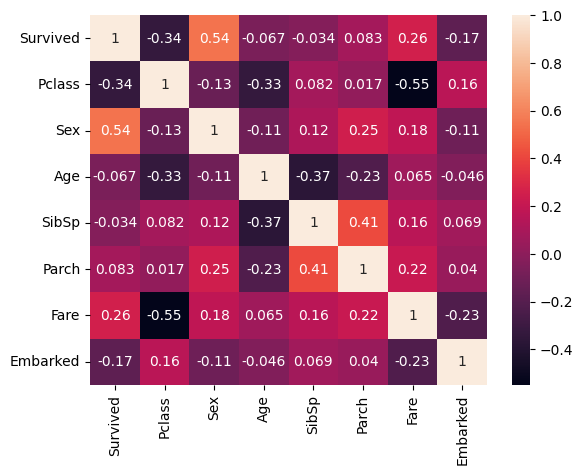

Valores não relacionados:
Age      0.066552
SibSp    0.034040
Parch    0.083151
Name: Survived, dtype: float64


In [265]:
#Vizualizar quais váriaveis são mais correlacionadas com a de sobrevivência
matrix = trainData.corr()
plt.figure()
sns.heatmap(matrix, annot=True)
plt.show()

corrSurvived = abs(matrix["Survived"])
print(f"Valores não relacionados:\n{corrSurvived[corrSurvived < 0.1]}")

Como podemos ver, a qtd de filhos e de conjugues não é um valor muito útil pra definir se a pessoa sobreviveu ou não. Então realizamos alguns tratamentos para tornar os dados mais úteis e removemos os dados brutos que podem causar ruído.

In [266]:
#Criamos essa coluna temporaria "FamilyCount" somando a qtd de filhos e de conjugues ao passageiro
#O dado mais relevante é saber se o passageiro está sozinho ou não.
trainData["FamilyCount"] = trainData['SibSp'] + trainData['Parch'] + 1
testData["FamilyCount"] = testData['SibSp'] + testData['Parch'] + 1
trainData['IsAlone'] = trainData["FamilyCount"] == 1
testData['IsAlone'] = testData["FamilyCount"] == 1

trainData = trainData.drop(["SibSp","Parch", "FamilyCount"], axis=1)
testData = testData.drop(["SibSp","Parch", "FamilyCount"], axis=1)

Verificando novamente:

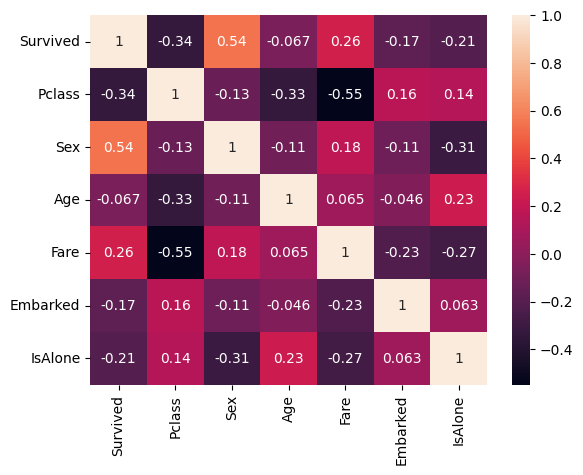

Valores não relacionados:
Age    0.066552
Name: Survived, dtype: float64


In [267]:
#Vizualizar quais váriaveis são mais correlacionadas com a de sobrevivência
matrix = trainData.corr()
plt.figure()
sns.heatmap(matrix, annot=True)
plt.show()

corrSurvived = abs(matrix["Survived"])
print(f"Valores não relacionados:\n{corrSurvived[corrSurvived < 0.1]}")

In [268]:
#idade continua pouco correlacionado à sobrevivência, então podemos remover

trainData = trainData.drop(["Age"], axis=1)
testData = testData.drop(["Age"], axis=1)

## ÁRVORE DE DECISÃO

Uma árvore de decisão é um modelo de aprendizado de máquina amplamente utilizado tanto para classificação quanto para regressão. O objetivo de uma árvore de decisão é fazer previsões sobre os dados, seguindo os caminhos da raiz até as folhas, baseando-se nas respostas aos testes realizados em cada nó. O caminho escolhido em cada nó depende do valor do atributo testado. Esse processo continua até que se alcance um nó folha, que fornece a previsão final.

In [269]:
trainX = trainData.drop(["Survived"], axis=1)
trainY = trainData["Survived"]

testX = testData.drop(["Survived"], axis=1)
testY = testData["Survived"]

In [270]:
model_no_limit = DecisionTreeClassifier(random_state=42)
model_no_limit.fit(trainX, trainY)
y_pred_no_limit = model_no_limit.predict(testX)
accuracy_no_limit = accuracy_score(testY, y_pred_no_limit)
conf_matrix_no_limit = confusion_matrix(testY, y_pred_no_limit)
print(f'Sem limitação de profundidade - Accuracy: {accuracy_no_limit}')
print(f'Sem limitação de profundidade - Confusion Matrix:\n{conf_matrix_no_limit}')

Sem limitação de profundidade - Accuracy: 0.8660287081339713
Sem limitação de profundidade - Confusion Matrix:
[[243  23]
 [ 33 119]]


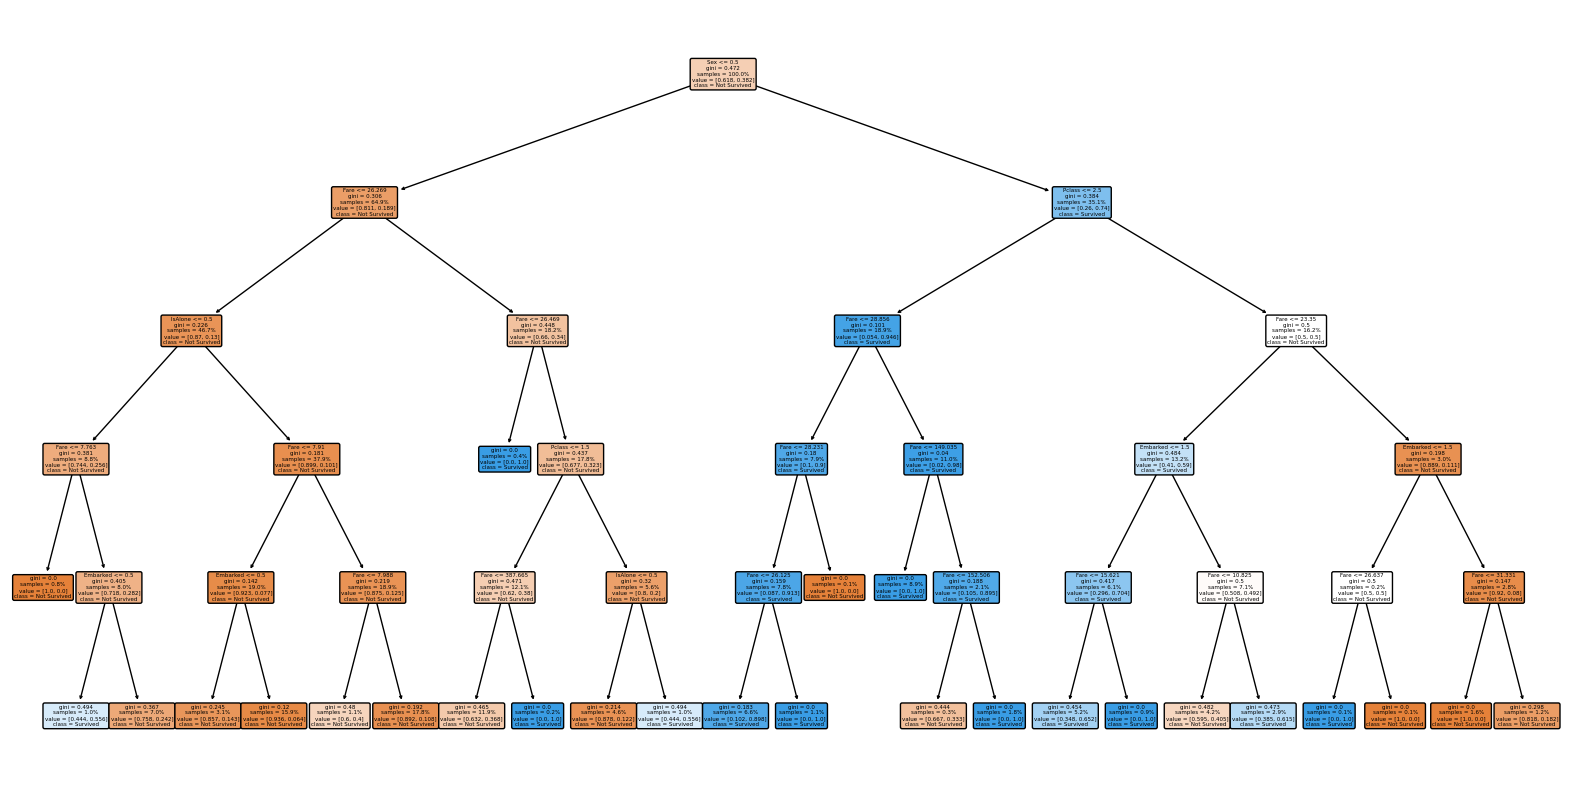

In [271]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(trainX, trainY)

# Plotando a árvore de decisão
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=trainX.columns, class_names=['Not Survived', 'Survived'], rounded=True, proportion=True)
plt.show()

# Variando parâmetros

A priori vamos modificar a altura da árvore, pois é uma técnica crucial para controlar a complexidade do modelo e, por sua vez, seu desempenho geral, especialmente em termos de generalização para dados não vistos. A profundidade de uma árvore de decisão se refere ao número máximo de níveis que separam a raiz da árvore de suas folhas mais distantes. Ajustar esse parâmetro tem implicações significativas, tanto para o overfitting quanto para o underfitting

In [272]:
model_with_limit = DecisionTreeClassifier(max_depth=5)
model_with_limit.fit(trainX, trainY)
y_pred_with_limit = model_with_limit.predict(testX)
accuracy_with_limit = accuracy_score(testY, y_pred_with_limit)
conf_matrix_with_limit = confusion_matrix(testY, y_pred_with_limit)
print(f'Com limitação de profundidade (max_depth=5) - Accuracy: {accuracy_with_limit}')
print(f'Com limitação de profundidade (max_depth=5) - Confusion Matrix:\n{conf_matrix_with_limit}')

Com limitação de profundidade (max_depth=5) - Accuracy: 0.9043062200956937
Com limitação de profundidade (max_depth=5) - Confusion Matrix:
[[251  15]
 [ 25 127]]


Para implementar a variação de parâmetros no código vimos que haviam dois bons modos usando GridSearchCV ou RandomizedSearchCV. Consideramos o primeiro pelo conhecimento dos impactos de cada variavél.

In [273]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 20, 40, 60, 80],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=42)

# Configuração do GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [274]:
grid_search.fit(trainX, trainY)

# Melhores parâmetros encontrados pelo GridSearchCV
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor precisão:", grid_search.best_score_)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 80, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor precisão: 0.8211705706849489


In [275]:
# Avaliação do modelo com os melhores parâmetros no conjunto de teste
best_model_with_limit = grid_search.best_estimator_
y_pred_with_limit = best_model_with_limit.predict(testX)
accuracy_with_limit = accuracy_score(testY, y_pred_with_limit)
conf_matrix_with_limit = confusion_matrix(testY, y_pred_with_limit)

print(f'Com os melhores parâmetros encontrados, incluindo max_depth - Accuracy: {accuracy_with_limit}')
print(f'Com os melhores parâmetros encontrados, incluindo max_depth - Confusion Matrix:\n{conf_matrix_with_limit}')


Com os melhores parâmetros encontrados, incluindo max_depth - Accuracy: 0.8803827751196173
Com os melhores parâmetros encontrados, incluindo max_depth - Confusion Matrix:
[[251  15]
 [ 35 117]]


# Stratified K-Fold

A Validação Cruzada Estratificada preserva a proporção original das classes em cada fold. Isso garante que cada conjunto de treinamento e teste seja representativo do conjunto de dados total, proporcionando uma avaliação mais precisa e confiável do modelo.

In [276]:
totalDataSet = pd.concat([trainData,testData])
X = totalDataSet.drop(["Survived"], axis=1)
Y = totalDataSet["Survived"]

accuracies = []
conf_matrices = []

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True)

for trainIndex, textIndex in stratified_cv.split(X, Y):
    f_trainX, f_testX = X.iloc[trainIndex], X.iloc[textIndex]
    f_trainY, f_testY = Y.iloc[trainIndex], Y.iloc[textIndex]

    model_with_limit = DecisionTreeClassifier(max_depth=5)
    model_with_limit.fit(f_trainX, f_trainY)

    y_pred_with_limit = model_with_limit.predict(f_testX)
    accuracies.append(accuracy_score(f_testY, y_pred_with_limit))
    conf_matrices.append(confusion_matrix(f_testY, y_pred_with_limit))

# Cálculo das métricas médias após a validação cruzada estratificada
mean_accuracy = np.mean(accuracies)
mean_conf_matrix = np.mean(conf_matrices, axis=0)

print(f'Média da Accuracy com limitação de profundidade (max_depth=5): {mean_accuracy}')
print(f'Média da Confusion Matrix com limitação de profundidade (max_depth=5):\n{mean_conf_matrix}')

IndexError: positional indexers are out-of-bounds

# Cost Complexity Pruning

RFE identifica e retem apenas as características mais significativas e, em seguida, aplico Cost Complexity Pruning para ajustar a complexidade da árvore de decisão resultante

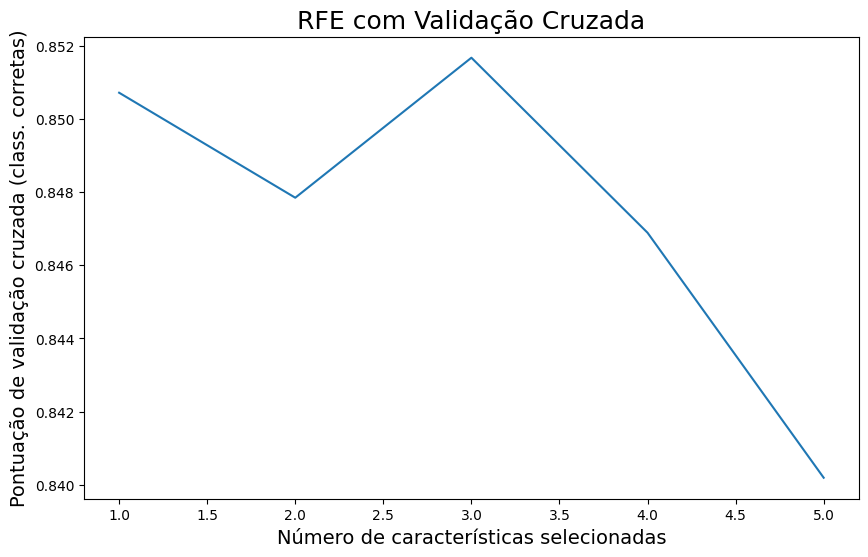

Número ótimo de características: 3
Características selecionadas: ['Pclass', 'Sex', 'Fare']
Melhor ccp_alpha: 0.00297098467469125
Acurácia do melhor modelo no conjunto de teste: 0.8854961832061069


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=dt, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.title('RFE com Validação Cruzada', fontsize=18)
plt.xlabel('Número de características selecionadas', fontsize=14)
plt.ylabel('Pontuação de validação cruzada (class. corretas)', fontsize=14)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

print("Número ótimo de características: %d" % rfecv.n_features_)
selected_features = [f for f, s in zip(X_train.columns, rfecv.support_) if s]
print("Características selecionadas:", selected_features)

X_train_reduced = X_train[selected_features]
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train_reduced, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#Treinamento com diferentes valores de ccp_alpha para achar o melhor
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train_reduced, y_train)
    clfs.append(clf)

# Encontrar a melhor precisão no conjunto de teste reduzido
X_test_reduced = X_test[selected_features]
acc_scores = [accuracy_score(y_test, clf.predict(X_test_reduced)) for clf in clfs]
best_alpha = ccp_alphas[np.argmax(acc_scores)]
best_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
best_clf.fit(X_train_reduced, y_train)

# Avaliar a precisão do melhor modelo
y_pred_best = best_clf.predict(X_test_reduced)
accuracy_best = accuracy_score(y_test, y_pred_best)

print(f'Melhor ccp_alpha: {best_alpha}')
print(f'Acurácia do melhor modelo no conjunto de teste: {accuracy_best}')


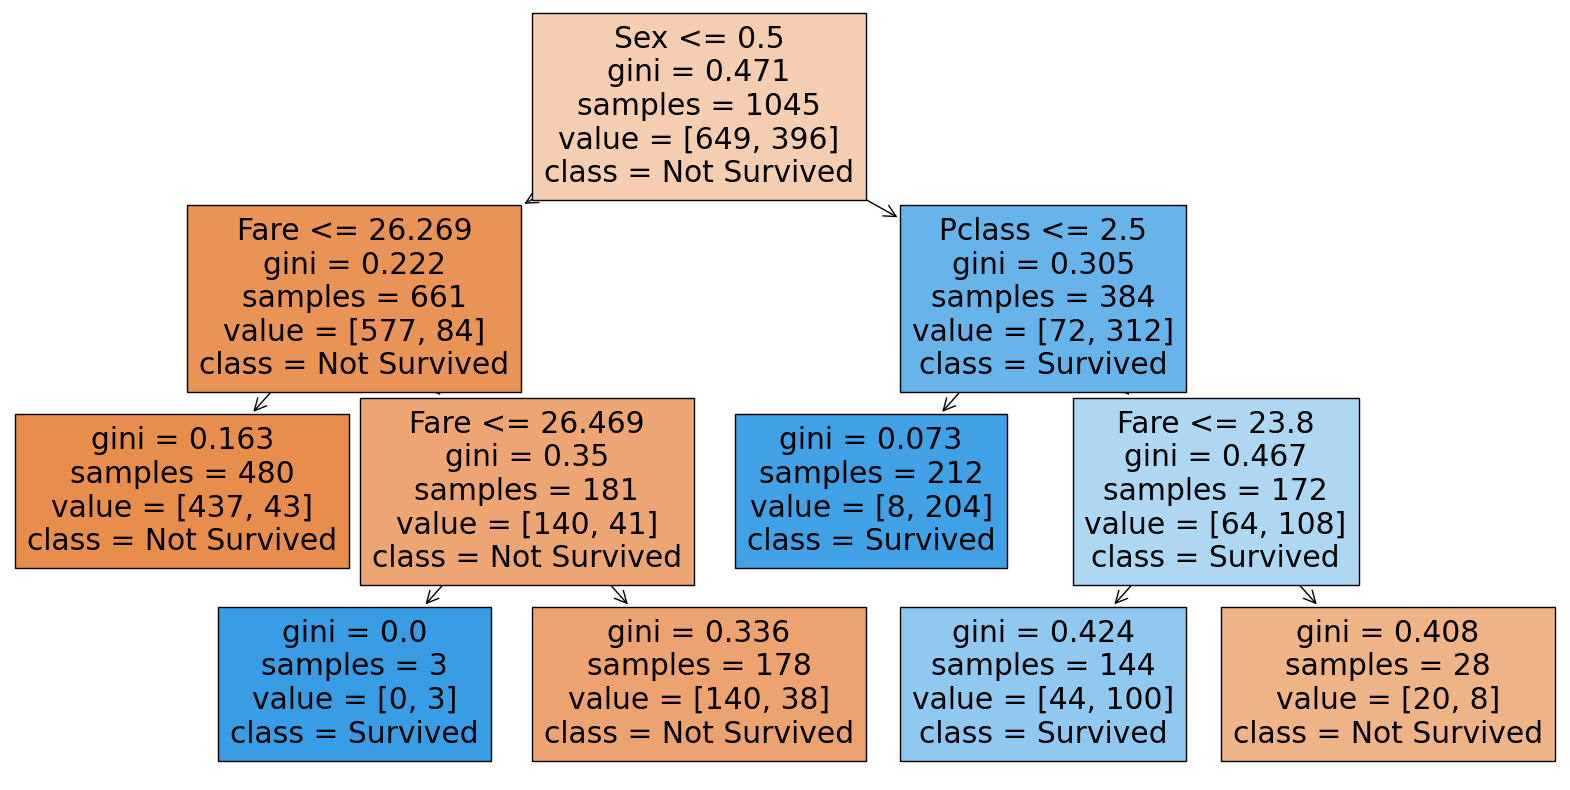

In [ ]:
#Melhor árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=selected_features, class_names=['Not Survived', 'Survived'])
plt.show()
